In [39]:
#Instalação de bibliotecas

     -------------------------------------- 725.5/725.5 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Bibliotecas em uso
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

## Exploração de dados
Exploração inicial dos dados de acidentes nos EUA

In [202]:
df = pd.read_csv('I:/OneDrive - det.ufc.br/Cursos Extras/Pos Ciencia de Dados e Big Data/TCC-PucMinas/Database/US_Accidents_Dec21_updated.csv')

In [203]:
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 120)

In [204]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45217,US,US/Eastern,KLUK,2016-02-08 07:53:00,37.0,29.8,93.0,29.69,10.0,WSW,10.4,0.01,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [207]:
#Formato do dataframe
print('A fonte de dados contem linhas: {:,d} e colunas: {}'.format(df.shape[0], df.shape[1]))

A fonte de dados contem linhas: 2,845,342 e colunas: 47


In [208]:
# Transformando as datas para o tipo correto
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            object        
 10  Number                 float64       
 11  Street                 object        
 12  Side                   object        
 13  City                   object        
 14  County                 object        
 15  State                  object        
 16  Zipcode                object        
 17  Country                object        
 18  Timezone              

In [22]:
df.isnull().sum()

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Number                   1743911
Street                         2
Side                           0
City                         137
County                         0
State                          0
Zipcode                     1319
Country                        0
Timezone                    3659
Airport_Code                9549
Weather_Timestamp          50736
Temperature(F)             69274
Wind_Chill(F)             469643
Humidity(%)                73092
Pressure(in)               59200
Visibility(mi)             70546
Wind_Direction             73775
Wind_Speed(mph)           157944
Precipitation(in)         549458
Weather_Condition          70636
Amenity   

In [38]:
df.isna().sum()

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Number                   1743911
Street                         2
Side                           0
City                         137
County                         0
State                          0
Zipcode                     1319
Country                        0
Timezone                    3659
Airport_Code                9549
Weather_Timestamp          50736
Temperature(F)             69274
Wind_Chill(F)             469643
Humidity(%)                73092
Pressure(in)               59200
Visibility(mi)             70546
Wind_Direction             73775
Wind_Speed(mph)           157944
Precipitation(in)         549458
Weather_Condition          70636
Amenity   

In [23]:
df.nunique()

ID                       2845342
Severity                       4
Start_Time               1807311
End_Time                 2239983
Start_Lat                1093618
Start_Lng                1120365
End_Lat                  1080811
End_Lng                  1105404
Distance(mi)               14165
Description              1174563
Number                     46402
Street                    159651
Side                           3
City                       11681
County                      1707
State                         49
Zipcode                   363085
Country                        1
Timezone                       4
Airport_Code                2004
Weather_Timestamp         474214
Temperature(F)               788
Wind_Chill(F)                897
Humidity(%)                  100
Pressure(in)                1068
Visibility(mi)                76
Wind_Direction                24
Wind_Speed(mph)              136
Precipitation(in)            230
Weather_Condition            127
Amenity   

In [24]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,2.845342e+06,1.101431e+06,2.776068e+06,2.375699e+06,2.772250e+06,2.786142e+06,2.774796e+06,2.687398e+06,2.295884e+06
mean,2.137572e+00,3.624520e+01,-9.711463e+01,3.624532e+01,-9.711439e+01,7.026779e-01,8.089408e+03,6.179356e+01,5.965823e+01,6.436545e+01,2.947234e+01,9.099391e+00,7.395044e+00,7.016940e-03
std,4.787216e-01,5.363797e+00,1.831782e+01,5.363873e+00,1.831763e+01,1.560361e+00,1.836009e+04,1.862263e+01,2.116097e+01,2.287457e+01,1.045286e+00,2.717546e+00,5.527454e+00,9.348831e-02
min,1.000000e+00,2.456603e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.344517e+01,-1.180331e+02,3.344628e+01,-1.180333e+02,5.200000e-02,1.270000e+03,5.000000e+01,4.600000e+01,4.800000e+01,2.931000e+01,1.000000e+01,3.500000e+00,0.000000e+00
50%,2.000000e+00,3.609861e+01,-9.241808e+01,3.609799e+01,-9.241772e+01,2.440000e-01,4.007000e+03,6.400000e+01,6.300000e+01,6.700000e+01,2.982000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.016024e+01,-8.037243e+01,4.016105e+01,-8.037338e+01,7.640000e-01,9.567000e+03,7.600000e+01,7.600000e+01,8.300000e+01,3.001000e+01,1.000000e+01,1.000000e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,1.551860e+02,9.999997e+06,1.960000e+02,1.960000e+02,1.000000e+02,5.890000e+01,1.400000e+02,1.087000e+03,2.400000e+01


In [52]:
#Agrupar por cidades
df_cidade = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'Cidade', 'City':'Acidentes'})
df_cidade.head(-5)

,Cidade,Acidentes
0,Miami,106966
1,Los Angeles,68956
2,Orlando,54691
3,Dallas,41979
4,Houston,39448
...,...,...
11671,Linn,1
11672,Stella,1
11673,York New Salem,1
11674,Algona,1


In [66]:
#Agrupar por estados
#Agrupar por cidades
df_estado = pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'Estado', 'City':'Acidentes'})
df_estado.head(10)

,Estado,State
0,CA,795868
1,FL,401388
2,TX,149037
3,OR,126341
4,VA,113535
5,NY,108049
6,PA,99975
7,MN,97185
8,NC,91362
9,SC,89216


In [67]:
#Nomes dos estados
df_state = pd.read_csv('I:/OneDrive - det.ufc.br/Cursos Extras/Pos Ciencia de Dados e Big Data/TCC-PucMinas/Database/state_name.csv',sep=';')

In [68]:
df_state.head()

,Estado,Nome
0,AK,Alaska
1,AL,Alabama
2,AR,Arkansas
3,AS,AmericanSamoa
4,AZ,Arizona


In [73]:
df_estado = pd.merge(df_estado, df_state, on='Estado')
# df_estado.drop(['state_x','name_x','state_y,','name_y' axis=1, inplace=True)
df_estado.drop('Nome_y', axis=1, inplace=True)
df_estado

,Estado,State,Nome
0,CA,795868,California
1,FL,401388,Florida
2,TX,149037,Texas
3,OR,126341,Oregon
4,VA,113535,Virginia
5,NY,108049,NewYork
6,PA,99975,Pennsylvania
7,MN,97185,Minnesota
8,NC,91362,NorthCarolina
9,SC,89216,SouthCarolina


In [74]:
df.value_counts("Severity")

Severity
2    2532991
3     155105
4     131193
1      26053
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

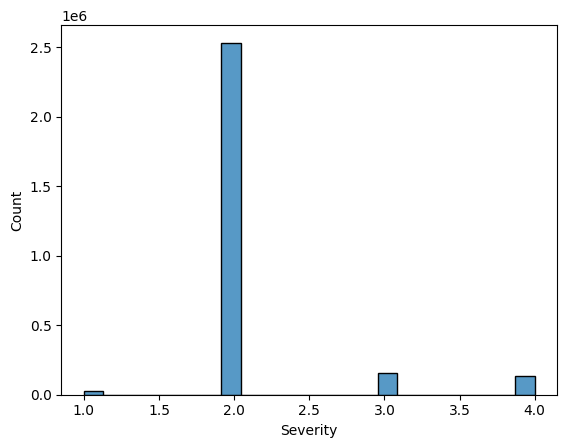

In [64]:
sns.histplot(data=df, x="Severity")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

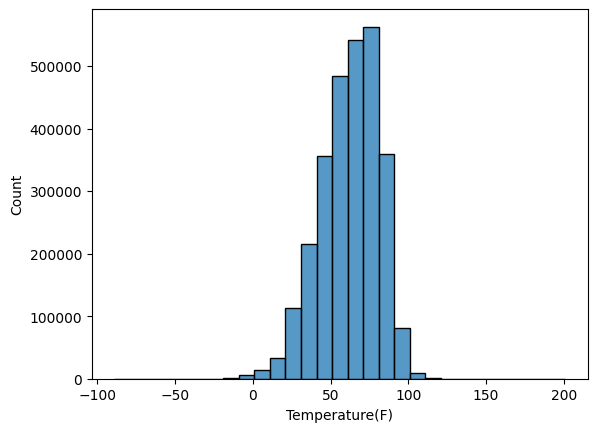

In [76]:
sns.histplot(data=df, x="Temperature(F)",binwidth=10)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

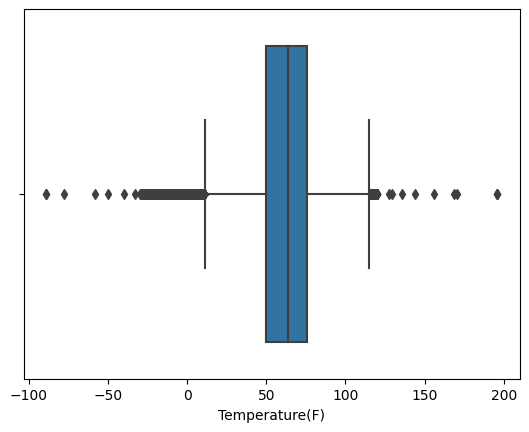

In [13]:
sns.boxplot(data=df, x="Temperature(F)")
plt.show

In [12]:
df.value_counts("Weather_Condition") 	

Weather_Condition
Fair                         1107194
Mostly Cloudy                 363959
Cloudy                        348767
Partly Cloudy                 249939
Clear                         173823
                              ...   
Low Drifting Snow                  1
Light Fog                          1
Mist / Windy                       1
Sand / Dust Whirls Nearby          1
Sleet / Windy                      1
Length: 127, dtype: int64

<Axes: xlabel='Severity', ylabel='Temperature(F)'>

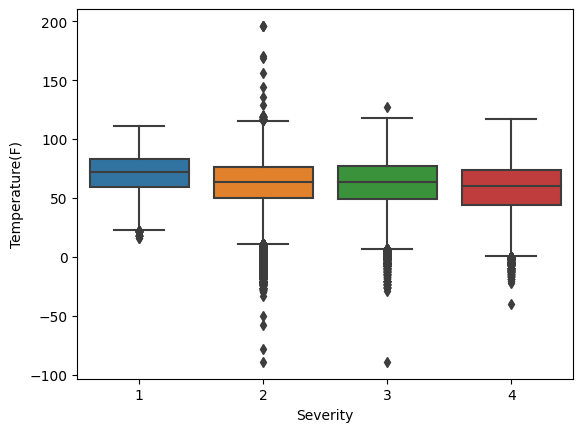

In [14]:
sns.boxplot(data=df, x='Severity', y='Temperature(F)')

<Axes: xlabel='Side', ylabel='Temperature(F)'>

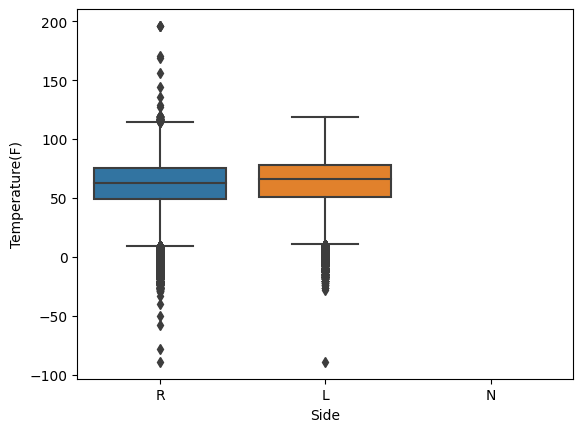

In [17]:
sns.boxplot(data=df, x='Side', y='Temperature(F)')

In [15]:
df.groupby('Severity').agg(media_temp=('Temperature(F)','mean'))

,media_temp
Severity,
1,71.257955
2,61.868632
3,61.920769
4,58.275355


In [27]:
#Colunas com infos de mes e ano
df['Data_mes'] = pd.to_datetime(df['Start_Time'], format='%m/%yyyy')
df['Data_ano'] = pd.to_datetime(df['Start_Time'], format='%yyyy')

In [35]:
df_grouped = df.groupby(pd.Grouper(key='Start_Time', freq='M')).mean()

C:\Users\William\AppData\Local\Temp\ipykernel_9616\4199387081.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(pd.Grouper(key='Start_Time', freq='M')).mean()


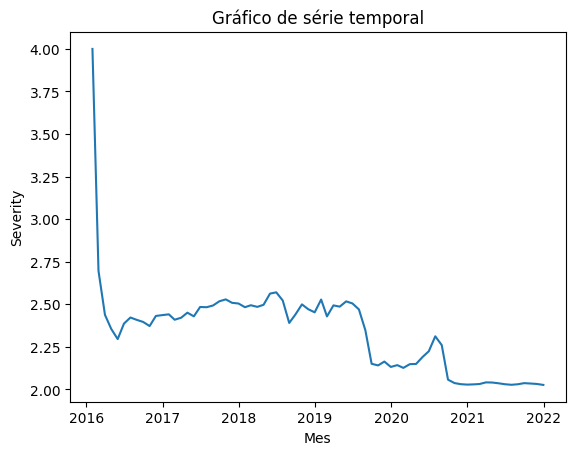

In [37]:
sns.lineplot(data=df_grouped, x='Start_Time', y='Severity')
plt.xlabel('Mes')
plt.ylabel('Severity')
plt.title('Gráfico de série temporal')
plt.show()

In [34]:
df_grouped.index

DatetimeIndex(['2016-01-14 20:18:33', '2016-02-08 00:37:08',
               '2016-02-08 05:56:20', '2016-02-08 06:15:39',
               '2016-02-08 06:51:45', '2016-02-08 07:53:43',
               '2016-02-08 08:15:41', '2016-02-08 08:16:57',
               '2016-02-08 11:51:46', '2016-02-08 14:19:57',
               ...
               '2021-12-31 22:36:13', '2021-12-31 22:37:00',
               '2021-12-31 22:37:11', '2021-12-31 22:39:30',
               '2021-12-31 22:40:00', '2021-12-31 22:41:00',
               '2021-12-31 22:42:00', '2021-12-31 23:22:00',
               '2021-12-31 23:26:30', '2021-12-31 23:30:00'],
              dtype='datetime64[ns]', name='Data_mes', length=1807311, freq=None)

## Limpeza de dados (Data cleaning)


## DataSet das informações por localização (WebScrapping)

In [181]:
locations = [
    {'latitude': 40.100006, 'longitude': -83.1, 'datahora': '2016-02-08T08:00'},
    {'latitude': 39.9612, 'longitude': -82.9988, 'datahora': '2016-02-08T09:00'},
    {'latitude': 41.8781, 'longitude': -87.6298, 'datahora': '2016-02-08T10:00'}]
data = {
    'latitude': [loc['latitude'] for loc in locations],
    'longitude': [loc['longitude'] for loc in locations],
    'datahora': [loc['datahora'] for loc in locations],
    'temperatura': []}

In [209]:
df_request = pd.DataFrame()
df_request["Latitude"] = df["Start_Lat"]
df_request["Longitude"] = df["Start_Lng"]
df_request["Time"] = pd.to_datetime(df["Start_Time"]).dt.strftime("%Y-%m-%d")

In [211]:
len(df_request)

2845342

In [214]:
df_request.head()

,Latitude,Longitude,Time
0,40.108910,-83.092860,2016-02-08
1,39.865420,-84.062800,2016-02-08
2,39.102660,-84.524680,2016-02-08
3,41.062130,-81.537840,2016-02-08
4,39.172393,-84.492792,2016-02-08


In [212]:
df_request = df_request.drop_duplicates()

In [216]:
len(df_request)

2437913

In [220]:
df_request.head(3)

,Latitude,Longitude,Time
0,40.10891,-83.09286,2016-02-08
1,39.86542,-84.06280,2016-02-08
2,39.10266,-84.52468,2016-02-08


In [197]:

request = requests.get(f'https://archive-api.open-meteo.com/v1/archive?latitude={}40.108910&longitude=-83.092860&start_date=2016-02-08&end_date=2016-02-08&hourly=apparent_temperature&hourly=precipitation')
df_request = request.json()
df_request

{'latitude': 40.100006,
 'longitude': -83.1,
 'generationtime_ms': 0.6209611892700195,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 270.0,
 'hourly_units': {'time': 'iso8601',
  'apparent_temperature': '°C',
  'precipitation': 'mm'},
 'hourly': {'time': ['2016-02-08T00:00',
   '2016-02-08T01:00',
   '2016-02-08T02:00',
   '2016-02-08T03:00',
   '2016-02-08T04:00',
   '2016-02-08T05:00',
   '2016-02-08T06:00',
   '2016-02-08T07:00',
   '2016-02-08T08:00',
   '2016-02-08T09:00',
   '2016-02-08T10:00',
   '2016-02-08T11:00',
   '2016-02-08T12:00',
   '2016-02-08T13:00',
   '2016-02-08T14:00',
   '2016-02-08T15:00',
   '2016-02-08T16:00',
   '2016-02-08T17:00',
   '2016-02-08T18:00',
   '2016-02-08T19:00',
   '2016-02-08T20:00',
   '2016-02-08T21:00',
   '2016-02-08T22:00',
   '2016-02-08T23:00'],
  'apparent_temperature': [3.2,
   2.8,
   2.0,
   1.0,
   1.1,
   1.1,
   1.0,
   0.9,
   0.2,
   -0.3,
   -0.5,
   -0.5,
   -0.6,
   -1.0,
   -1.

In [ ]:
# Cria um novo dataframe vazio
result_df = pd.DataFrame()

# Itera sobre as linhas do dataframe
for index, row in df.iterrows():
    latitude = row["latitude"]
    longitude = row["longitude"]
    date = row["datetime"].strftime("%Y-%m-%d") # Converte a data para o formato esperado pela API
    url = f'https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={date}&end_date={date}&hourly=apparent_temperature&hourly=precipitation'
    response = requests.get(url)
    # Processa a resposta aqui
    data = response.json() # Converte a resposta em um dicionário Python
    # Extrai os valores desejados do dicionário
    temperature = data["data"][0]["apparent_temperature"]
    precipitation = data["data"][0]["precipitation"]
    # Cria um novo dicionário com os valores extraídos
    result = {"latitude": latitude, "longitude": longitude, "date": date, "apparent_temperature": temperature, "precipitation": precipitation}
    # Adiciona o novo dicionário ao dataframe de resultados
    result_df = result_df.append(result, ignore_index=True)

In [201]:
# carrega o json como um dicionário
# dados_json = '{"latitude": 40.100006, "longitude": -83.1, "generationtime_ms": 0.41496753692626953, "utc_offset_seconds": 0, "timezone": "GMT", "timezone_abbreviation": "GMT", "elevation": 270.0, "hourly_units": {"time": "iso8601", "apparent_temperature": "°C", "precipitation": "mm"}, "hourly": {"time": ["2016-02-08T00:00", "2016-02-08T01:00"], "apparent_temperature": [3.2, 2.8], "precipitation": [0.0, 0.0]}}'
dados_dict = (df_request)

# cria um DataFrame a partir do dicionário
df_temp_prec = pd.DataFrame(dados_dict['hourly'])

# verifica se os valores de temperatura e precipitação são listas
if isinstance(df_temp_prec['time'][0], list):
    df_temp_prec['time'] = df_temp_prec['time'].apply(lambda x: x[0])
if isinstance(df_temp_prec['apparent_temperature'][0], list):
    df_temp_prec['apparent_temperature'] = df_temp_prec['apparent_temperature'].apply(lambda x: x[0])
if isinstance(df_temp_prec['precipitation'][0], list):
    df_temp_prec['precipitation'] = df_temp_prec['precipitation'].apply(lambda x: x[0])

# adiciona as informações do tempo ao DataFrame
df_temp_prec['latitude'] = dados_dict['latitude']
df_temp_prec['longitude'] = dados_dict['longitude']

# reorganiza as colunas do DataFrame
df_temp_prec = df_temp_prec[['latitude', 'longitude','time', 'apparent_temperature', 'precipitation']]

# exibe o DataFrame resultante
print(df_temp_prec)

     latitude  longitude              time  apparent_temperature  \
0   40.100006      -83.1  2016-02-08T00:00                   3.2   
1   40.100006      -83.1  2016-02-08T01:00                   2.8   
2   40.100006      -83.1  2016-02-08T02:00                   2.0   
3   40.100006      -83.1  2016-02-08T03:00                   1.0   
4   40.100006      -83.1  2016-02-08T04:00                   1.1   
5   40.100006      -83.1  2016-02-08T05:00                   1.1   
6   40.100006      -83.1  2016-02-08T06:00                   1.0   
7   40.100006      -83.1  2016-02-08T07:00                   0.9   
8   40.100006      -83.1  2016-02-08T08:00                   0.2   
9   40.100006      -83.1  2016-02-08T09:00                  -0.3   
10  40.100006      -83.1  2016-02-08T10:00                  -0.5   
11  40.100006      -83.1  2016-02-08T11:00                  -0.5   
12  40.100006      -83.1  2016-02-08T12:00                  -0.6   
13  40.100006      -83.1  2016-02-08T13:00      

In [196]:
dados_dict

{'latitude': 40.100006,
 'longitude': -83.1,
 'generationtime_ms': 0.41496753692626953,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 270.0,
 'hourly_units': {'time': 'iso8601',
  'apparent_temperature': '°C',
  'precipitation': 'mm'},
 'hourly': {'time': ['2016-02-08T00:00', '2016-02-08T01:00'],
  'apparent_temperature': [3.2, 2.8],
  'precipitation': [0.0, 0.0]}}

In [148]:
data = json.loads(df_request.text)

AttributeError: 'dict' object has no attribute 'text'